# analyzing Annihilation Rates from the Oscillatory Model
Tim Tyree<br>
1.10.2022

In [8]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# !pip install mpltools

In [10]:
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [ ]:
#TODO(later?): dev averaging step for computation of powerlaw fits.
# Option 2: map run_21_all to run_21_all_merged using the averaging filter
# Option 1: see if the run_21_all.csv already did all of the merging for me, in which case I can connect run_21_all.csv to the bootstrapping method already in use.

# visualize annihilation rates when using the noninteracting model for phase evolution, to show the correct exponents were not observed

In [149]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [158]:
#interactionlesss processing phases with vector summed forces
# data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_21_all.csv"
#exponential concurrency between neighbors
# data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_22_all.csv"
data_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_23_all.csv"
df=pd.read_csv(data_dir)
# df.head()

print(list(df.columns))

assert (not (df.CollRate<0).any())

['x0', 'varkappa', 'set_second', 'reflect', 'r', 'no_repulsion', 'no_attraction', 'niter', 'neighbor', 'kappa', 'force_code', 'dt', 'N', 'L', 'Dt', 'D', 'CollRate']


In [159]:
#derived values
# df['CollRate']=1./df['CollTime']
df['A']=df['L']**2
df['q']=df['N']/df['A'] #number of tips per square centimeter
df['w']=df['CollRate']/df['A'] #[mHz?]/cm^2

# df=df[df.niter==250].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s
varkappa_values=np.array(sorted(set(df.varkappa.values)))#1/s
x0_values=np.array(sorted(set(df.x0.values)))#1/s
set_second_values=np.array(sorted(set(df.set_second.values)))
reflect_values=np.array(sorted(set(df.reflect.values)))
no_repulsion_values=np.array(sorted(set(df.no_repulsion.values)))
no_attraction_values=np.array(sorted(set(df.no_attraction.values)))
neighbor_values=np.array(sorted(set(df.neighbor.values)))
force_code_values=np.array(sorted(set(df.force_code.values)))

#make test for whether there is one input parameter present in an input DataFrame
print(f"parameters:")
print(f"r~{r_values}")
print(f"D~{D_values}")
print(f"L~{L_values}")
print(f"kappa~{kappa_values}")
print(f"a~{varkappa_values}")
print(f"x0~{x0_values}")
print(f"set_second~{set_second_values}")
print(f"reflect~{reflect_values}")
print(f"no_repulsion~{no_repulsion_values}")
print(f"no_attraction~{no_attraction_values}")
print(f"neighbor~{neighbor_values}")
print(f"force_code~{force_code_values}")

parameters:
r~[0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8
 0.85 0.9  0.95 1.  ]
D~[0.20052 0.44199 0.80208 1.76795]
L~[10]
kappa~[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500]
a~[0.40104 0.88398 1.60415 3.5359 ]
x0~[0.05 0.06 0.1  0.12]
set_second~[0]
reflect~[0]
no_repulsion~[0]
no_attraction~[0]
neighbor~[1]
force_code~[2]


In [160]:
#DONE: what settings finished?
#DONE: ask self which ~half of settings did not finish.  LR finished. FK was not attempted.  i'd bet the low kappa*r**2 trials failed to finish
#TODO(later): add minimum r**2*kappa threshold to gen_run_22.py
#DONE: did any powerlaw fits have a reasonably low RMSE_full? No. 
#DONE: visualize individual settings

Note: Run 21 is missing trials from the neighbor=0 case.

I should consider why the neighbor=0 trials didn't finish if I try inplementing neighbor-neighbor phase interactions.

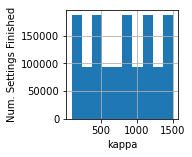

In [161]:
#plot the histogram of parameter values for settings that finished
x_col='kappa'
fig,ax=plt.subplots(figsize=(2,2))
df[x_col].hist(ax=ax)
format_plot(ax=ax,xlabel=x_col,ylabel='Num. Settings Finished',fontsize=10)
plt.show()

In [182]:
#Warning: computed powerlaw fits for  >5000 trials successfully.
#what do the annihilation rates look like?
#for FK model
#query the control
varkappa=varkappa_values[-1] #cm^2/s
D=D_values[-1]
r=r_values[0]
L=L_values[0]
x0=x0_values[-2] #s

# kappa=kappa_values[4]
kappa=100
x0=0.1
r=0.3

#token setting from run 23
r=0.5
D=1.76795
L=10
varkappa=3.5359
x0=0.10
kappa=100

set_second=0
no_repulsion=0
no_attraction=0
reflect=0
neighbor=1
force_code=force_code_values[0]

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
# print(df[query].size)
query&=df.D==D
# print(df[query].size)
query&=df.L==L
# print(df[query].size)
query&=df.varkappa==varkappa
# print(df[query].size)
query&=df.x0==x0
# print(df[query].size)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
print(df[query].size)
query&=(df.neighbor==neighbor)
print(df[query].size)
query&=(df.force_code==force_code)
print(df[query].size)
dg=df[query]
kappa_values=np.array(sorted(set(dg.kappa.values)))
print(df[query].size)

24300
24300
24300
24300


(0.5, 1.76795, 10, 100, 3.5359, 0.1)


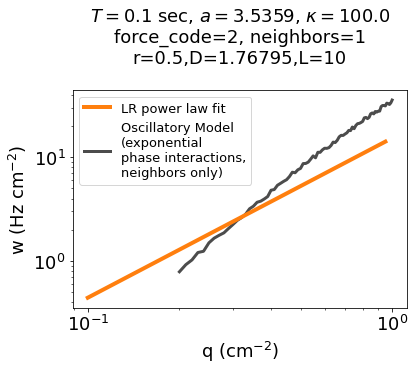

In [183]:
#select which parameter settings to use
# # kappa=kappa_values[4]
# kappa=1500
# # x0=x0_values[0]        #cm
# x0=0.1
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_control=x_values.copy()
y_values_control=y_values.copy()

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=df.r==r
query&=df.D==D
query&=df.L==L
query&=df.varkappa==varkappa
query&=df.x0==x0
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
dg=df[query]

# kappa_values=np.array(sorted(set(dg.kappa.values)))
# kappa=kappa_values[1]
dh=dg[dg.kappa==kappa]
x_values=dh.q.values
y_values=dh.w.values
x_values_test=x_values.copy()
y_values_test=y_values.copy()
print((r,D,L,kappa,varkappa,x0))

#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
# plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')

fontsize=18
# plt.plot(x_values_control,y_values_control,'-',c='k',alpha=.7,label=r'approx. infinite basin',lw=3)
plt.plot(x_values_test,y_values_test,'-',c='k',alpha=.7,label=f'Oscillatory Model\n(exponential\nphase interactions,\nneighbors only)',lw=3)

# plt.plot(x_values,y_values,c='C2',alpha=.7,label='simulation',lw=6)
# plt.plot(x_values_force,y_values_force,c='C3',alpha=.7,label='simulation with forces',lw=6)
# plt.plot(x_values,y_values,c=c_values,alpha=0.4,cmap='bwr')
# plt.title(u'comparison to simulation\nwith two hybrid modes',fontsize=fontsize)
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
# plt.xlim([0.08,1])

# print(f'varkappa={varkappa}  Hz');print(f'      x0={x0} cm')
# plt.title(r'$\varkappa=$'+f'{varkappa}  Hz, '+r'$x_0=$'+f'{x0} cm\nforce_code={force_code}, neighbors={neighbor}\n',fontsize=fontsize)
plt.title(r'$T=$'+f'{x0} sec, '+r'$a=$'+f'{varkappa}, '+r'$\kappa=$'+f'{kappa:.1f}\nforce_code={force_code}, neighbors={neighbor}\nr={r},D={D},L={L}\n',fontsize=fontsize)
plt.show()

In [55]:
# from generation of powerfits .ipynb
np.sqrt(3)*0.1

0.17320508075688773

In [150]:
# #run 21 (interactionless)
# powerfit_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_21_all_powerlaw_fits.csv'
# #run 22 (exponential neighbors) used 'q_max':0.4,
# powerfit_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_22_all_powerlaw_fits.csv'
# #run 23 (exponential neighbors, larger r) used 'q_max':0.4,
powerfit_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_23_all_powerlaw_fits.csv"

In [151]:
df_powerfits=pd.read_csv(powerfit_dir)
df_powerfits.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,2.229480,0.061599,9.638620,1.333950,0.996633,0.021009,0.109596,fk_pbc,0.2,0.4,...,0.44199,1.60415,0.10,10,2,1,0,0,0,0
1,5.235155,0.227042,1390.457266,1036.396337,0.991745,0.398202,2.462978,lr_pbc,0.2,0.4,...,0.44199,0.40104,0.10,10,2,1,0,0,0,0
2,3.393820,0.076842,149.718579,33.119521,0.997737,0.110419,1.080990,lr_pbc,0.2,0.4,...,1.76795,0.88398,0.12,10,2,1,0,0,0,0
3,6.154462,0.382619,24561.753517,46795.974315,0.983184,5.386465,31.759323,lr_pbc,0.2,0.4,...,0.44199,0.40104,0.12,10,2,1,0,0,0,0
4,4.449953,0.279246,4814.825006,6212.833607,0.982872,4.783878,35.686468,lr_pbc,0.2,0.4,...,1.76795,1.60415,0.05,10,2,1,0,0,0,0


In [181]:
df_powerfits.sort_values(by='rmse_full',inplace=True)
df_powerfits[(df_powerfits['model_name_full']=='lr_pbc')][['r','D','L','varkappa','x0', 'kappa']].head()

,r,D,L,varkappa,x0,kappa
14011,0.5,0.20052,10,3.5359,0.05,100
9109,0.5,1.76795,10,3.5359,0.10,100
14981,0.5,0.80208,10,3.5359,0.06,100
14389,0.5,0.44199,10,3.5359,0.05,100
2550,0.5,1.76795,10,3.5359,0.06,100


In [185]:
num_settings=df_powerfits.shape[0]

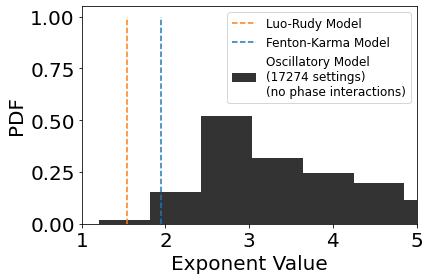

In [186]:
nu_values=df_powerfits['m'].values
yv=np.linspace(0,1,10)
plt.plot(0.*yv+m_lr,yv,'C1--',label='Luo-Rudy Model')
plt.plot(0.*yv+m_fk,yv,'C0--',label='Fenton-Karma Model')
plt.hist(nu_values,color='k',alpha=0.8,label=f'Oscillatory Model\n({num_settings} settings)\n(no phase interactions)',density=True)
format_plot(ax=plt.gca(),xlabel='Exponent Value',ylabel='PDF')
plt.legend(fontsize=12)
plt.xlim([1,5])
plt.show()

In [67]:
#TODO: how many neighbor=0 trials finished? how many neighbor=1 trials finished
#TODO: make ^this into a pie chart, because the same number of settings were attempted for neighbor=0 versus 1

In [154]:
num_neighor_settings=df[df.neighbor==1].w.values.shape[0]
num_non_neighor_settings=df[df.neighbor==0].w.values.shape[0]
print(f"{100*num_neighor_settings/(num_neighor_settings+num_non_neighor_settings):.2f}% percent of settings that terminated used neighbor-only forces.")

100.00% percent of settings that terminated used neighbor-only forces.


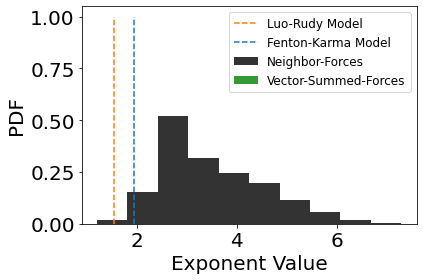

In [155]:
#meant for run 21 (interactionless)
yv=np.linspace(0,1,10)
plt.plot(0.*yv+m_lr,yv,'C1--',label='Luo-Rudy Model')
plt.plot(0.*yv+m_fk,yv,'C0--',label='Fenton-Karma Model')
nu_values=df_powerfits[df.neighbor==1]['m'].values
plt.hist(nu_values,color='k',alpha=0.8,label=f'Neighbor-Forces',density=True)
nu_values=df_powerfits[df.neighbor==0]['m'].values
plt.hist(nu_values,color='g',alpha=0.8,label=f'Vector-Summed-Forces',density=True)
format_plot(ax=plt.gca(),xlabel='Exponent Value',ylabel='PDF')
plt.legend(fontsize=12)
plt.show()

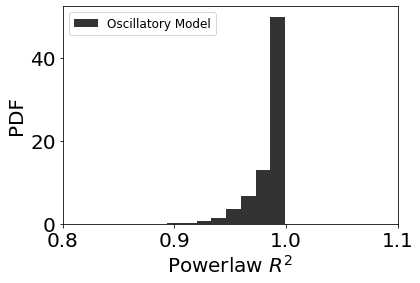

In [187]:
# yv=np.linspace(0,1,10)
# plt.plot(0.*yv+M_lr,yv,'C1--',label='Luo-Rudy Model')
# plt.plot(0.*yv+M_fk,yv,'C0--',label='Fenton-Karma Model')
M_values=df_powerfits[df.neighbor==1]['Rsq'].values
plt.hist(M_values,color='k',alpha=0.8,label=f'Oscillatory Model',density=True)
# nu_values=df_powerfits[df.neighbor==0]['m'].values
# plt.hist(nu_values,color='g',alpha=0.8,label=f'Vector-Summed-Forces',density=True)
format_plot(ax=plt.gca(),xlabel=r'Powerlaw $R^2$',ylabel='PDF')
plt.legend(fontsize=12)
plt.xlim([0.8,1.1])
plt.show()

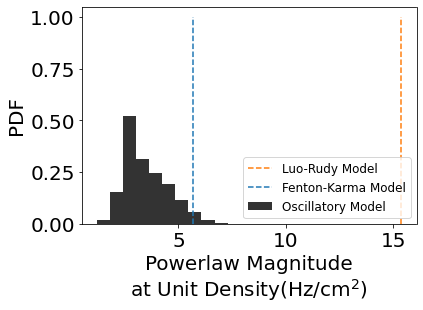

In [157]:
yv=np.linspace(0,1,10)
plt.plot(0.*yv+M_lr,yv,'C1--',label='Luo-Rudy Model')
plt.plot(0.*yv+M_fk,yv,'C0--',label='Fenton-Karma Model')
M_values=df_powerfits[df.neighbor==1]['m'].values
plt.hist(M_values,color='k',alpha=0.8,label=f'Oscillatory Model',density=True)
# nu_values=df_powerfits[df.neighbor==0]['m'].values
# plt.hist(nu_values,color='g',alpha=0.8,label=f'Vector-Summed-Forces',density=True)
# format_plot(ax=plt.gca(),xlabel=r'Powerlaw Magnitude (Hz/cm$^{2(1+\nu)}$)',ylabel='PDF')
format_plot(ax=plt.gca(),xlabel=f'Powerlaw Magnitude\nat Unit Density'+r'(Hz/cm$^2$)',ylabel='PDF')
plt.legend(fontsize=12)
plt.show()

$$
w=Mq^\nu
$$

$$
w=w_1(q/q_1)^\nu
$$

Let $q_1=1$ particle per square centimeter.

In [92]:
#DONT: #compute unit density of the full models
# q1_lr=M_lr**m_lr
# q1_fk=M_fk**m_fk
# q1_lr,q1_fk

In [188]:
#compute*np.pi*kappa*r^2
df_powerfits=pd.read_csv(powerfit_dir)
df=df_powerfits
# df['q1']=df['M']**df['m']
df['beta']=np.pi*df['r']**2*df['kappa']/2

Define the reaction coefficient, $\beta=\frac{1}{2}\kappa \pi r^2$.

In [189]:
df_powerfits.columns

Index(['m', 'Delta_m', 'M', 'Delta_M', 'Rsq', 'rmse', 'rmse_full',
       'model_name_full', 'q_min', 'q_max', 'r', 'kappa', 'D', 'varkappa',
       'x0', 'L', 'force_code', 'neighbor', 'reflect', 'set_second',
       'no_repulsion', 'no_attraction', 'beta'],
      dtype='object')

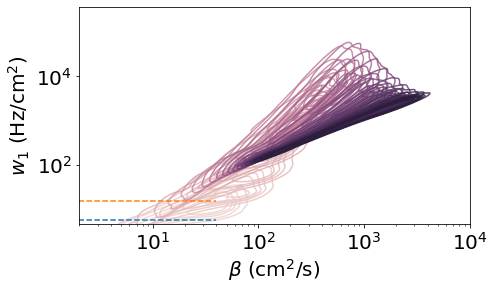

In [196]:
#TODO: scatter plot q1 versus beta
neighbor=1
x_col='beta'
xlabel=r'$\beta$ (cm$^2$/s)'
y_col='M'
ylabel=r'$w_1$ (Hz/cm$^2$)'
fig,ax=plt.subplots(figsize=(7,4))
xvmax=40
xv=np.linspace(0,xvmax,10)
ax.plot(xv,0.*xv+M_lr,'C1--')#,label='Luo-Rudy Model')
ax.plot(xv,0.*xv+M_fk,'C0--')#,label='Fenton-Karma Model')

retval=sns.kdeplot(
    data=df_powerfits[df.neighbor==neighbor], x=x_col, y=y_col, 
    hue="r", fill=False,alpha=0.8,levels=7,cmap='Spectral',vmin=0,vmax=0.5,
    log_scale=True,legend=False
)
# skde=sns.kdeplot(
#     data=df_powerfits[df.neighbor==neighbor], x=x_col, y=y_col, 
#     hue="r", fill=True,alpha=0.2,levels=3,cmap='Spectral',vmin=0,vmax=0.12)#,loc='lower right')
# skde.legend(loc='lower right')


format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel)#,use_loglog=True)
ax.set_xlim([2,1e4])

plt.show()

In [118]:
leg=retval.get_legend()


In [195]:
sns.kdeplot?

matplotlib.axes._subplots.AxesSubplot

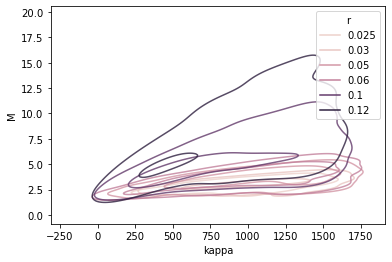

In [105]:
retval=sns.kdeplot(
    data=df_powerfits[df.neighbor==neighbor], x=x_col, y=y_col, 
    hue="r", fill=False,alpha=0.8,levels=3
)
format_plot(ax=plt.gca(),xlabel=xlabel,ylabel=ylabel)
type(retval)

# Plot Annihilation Rates Directly from Simulation Output

In [21]:
# input_fn=f"/Users/timothytyree/Documents/GitHub/bgmc/doc/plugging-oscillatory-params-into-parrticle-model.txt"
input_fn=f"/Users/timothytyree/Documents/GitHub/bgmc/c/oscillatory/fitty-output-lr.txt"

In [22]:
qfoo=lambda x:True
cwd=os.getcwd()
if qfoo is None:
    qfoo_pbc=lambda dict_inputs:dict_inputs['reflect']==0 #periodic bc
    qfoo_rbc=lambda dict_inputs:dict_inputs['reflect']==1 #reflecting bc
    # pick a general query function...
    qfoo=qfoo_rbc
df=po.parse_log(input_fn,qfoo,include_inputs=True,printing=True)
df.head()

input parameters were:
['r', 'D', 'L', 'kappa', 'varkappa', 'x0', 'dt', 'Dt', 'niter', 'reflect', 'set_second', 'no_repulsion', 'no_attraction', 'neighbor', 'force_code']
[0.1732, 1.76795, 10, 500, 3.5359, 0.1, 1e-05, 1e-05, 500, 0, 0, 0, 0, 1, 2]
returning outputs as pandas.DataFrame instance


,N,CollTime,r,D,L,kappa,varkappa,x0,dt,Dt,niter,reflect,set_second,no_repulsion,no_attraction,neighbor,force_code
0,100,0.021483,0.1732,1.76795,10,500,3.5359,0.1,0.00001,0.00001,500,0,0,0,0,1,2
1,99,0.023562,0.1732,1.76795,10,500,3.5359,0.1,0.00001,0.00001,500,0,0,0,0,1,2
2,98,0.025243,0.1732,1.76795,10,500,3.5359,0.1,0.00001,0.00001,500,0,0,0,0,1,2
3,97,0.027347,0.1732,1.76795,10,500,3.5359,0.1,0.00001,0.00001,500,0,0,0,0,1,2
4,96,0.032867,0.1732,1.76795,10,500,3.5359,0.1,0.00001,0.00001,500,0,0,0,0,1,2


True

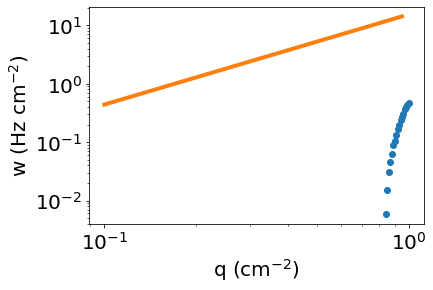

In [25]:
#plot fits for full model
m_fk=1.945;#+-0.030; B_fk=2.441+-0.051
m_lr=1.544;#+-0.034; B_lr=5.870+-0.137
M_fk=5.67;#+-0.39 Hz*cm^{2(m-1)}
M_lr=15.37;#+-1.57 Hz*cm^{2(m-1)}
# RMSE_fk=0.1252 Hz/cm^2
# RMSE_lr=0.0974 Hz/cm^2
# R^2=0.997 (FK)
# R^2=0.994 (LR)
# yscale=10**3
xv=np.arange(0.1,1.,.05)
yv_fk=M_fk*(xv)**m_fk
yv_lr=M_lr*(xv)**m_lr

fontsize=16
# plt.xlim([0.1,1])
# plt.ylim([1e-1,15])
plt.yscale('log')
plt.xscale('log')
# plt.plot(xv,yv_fk,label='FK power law fit',zorder=3,lw=4)
plt.plot(xv,yv_lr,label='LR power law fit',zorder=3,lw=4,color='C1')


df['q']=df['N']/(df['L']**2)
df['w']=(df['CollTime']**-1)/(df['L']**2)
x_values=df['q']
y_values=df['w']
plt.scatter(x_values,y_values)
format_plot(ax=plt.gca(),xlabel=r'q (cm$^{-2}$)',ylabel=r'w (Hz cm$^{-2}$)',use_loglog=True)